### 關於InfoGAN
ref: [這裡](https://mp.weixin.qq.com/s?__biz=MzI3MzkyMzE5Mw==&mid=2247485031&idx=1&sn=e6ccbc33639462d59ee56923c59173b6&chksm=eb1aab71dc6d2267cc52bf769106067c53c867ad6a02063791674937857fb86da36ecd6cbfd9&token=1864035800&lang=zh_CN#rd%20%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%E2%80%94%20%E7%89%88%E6%9D%83%E5%A3%B0%E6%98%8E%EF%BC%9A%E6%9C%AC%E6%96%87%E4%B8%BACSDN%E5%8D%9A%E4%B8%BB%E3%80%8C%E5%A5%BD%E7%A8%8B%E5%BA%8F%E4%B8%8D%E8%84%B1%E5%8F%91%E3%80%8D%E7%9A%84%E5%8E%9F%E5%88%9B%E6%96%87%E7%AB%A0%EF%BC%8C%E9%81%B5%E5%BE%AACC%204.0%20BY-SA%E7%89%88%E6%9D%83%E5%8D%8F%E8%AE%AE%EF%BC%8C%E8%BD%AC%E8%BD%BD%E8%AF%B7%E9%99%84%E4%B8%8A%E5%8E%9F%E6%96%87%E5%87%BA%E5%A4%84%E9%93%BE%E6%8E%A5%E5%8F%8A%E6%9C%AC%E5%A3%B0%E6%98%8E%E3%80%82%20%E5%8E%9F%E6%96%87%E9%93%BE%E6%8E%A5%EF%BC%9Ahttps://blog.csdn.net/ningmengzhihe/article/details/125500558)

1. 半監督式
2. 輸入的地方添加一組有特定label的數據，再拿來做訓練
3. 活用特徵學習，在不用對數據標注的情況下，有控制地輸出特定特徵的圖(ex.傾斜數字)
4. GAN的核心：數據不足的情況下，學習特徵來擴張數據集 -> infoGAN能將無標註的data學習成有標註的

其他：更[詳細介紹](https://www.jianshu.com/p/fa892c81df60)

### infoGAN理論：

1. 輸入添加某特定參數，讓model學習隱含特徵，且加入c之後entropy會減少（亂度下降，特定參數趨於明顯）
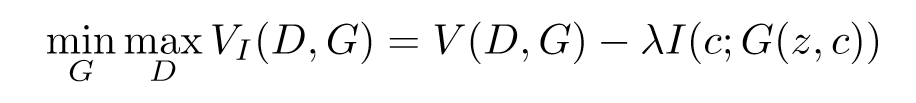

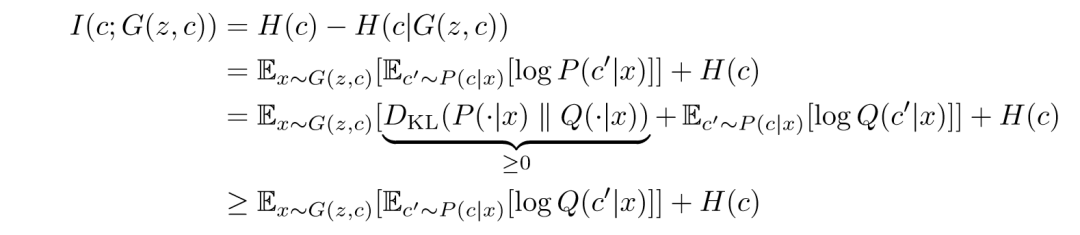

### MNIST常用參數設計：



c1（长度为10），用来控制输出具体是哪个类别（有监督）

c2,c3，挖掘隐含信息（并用c2,c3来控制隐含信息）（无监督）。



c1的计算Q(c|x)，很明显就是分类器常用的交叉熵

c2,c3，为了挖掘隐含信息，只需要保证和初始的输入一致即可，用MSE。



保持一致为什么可以保证获取隐含信息：



输入的信息c2,c3，在融入到G生成图片中，体现为图片的某些特征。

当且仅当图片中存在着有规律的c2,c3通过G映射出来的特征时，才能保证被D的特征挖掘的时候被获取到。因此如果能保证前后一致的话，那么说明c2,c3可以控制在G生成的图片表现出某种特征。

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.utils.data import DataLoader

#### 生成器架構


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()

        strides = [1, 2, 2, 2]#4種不同的strides
        padding = [0, 1, 1, 1]
        channels = [input_size,
                    256, 128, 64, 1]  # 1表示一维
        kernels = [4, 3, 4, 4]

        model = []
        for i, stride in enumerate(strides): #同個model架構下，四種不同的參數嘗試，分別有4大層
            model.append(
                nn.ConvTranspose2d(
                    in_channels=channels[i], 
                    out_channels=channels[i + 1],
                    stride=stride,
                    kernel_size=kernels[i],
                    padding=padding[i]
                )
            )

            if i != len(strides) - 1:
                model.append(
                    nn.BatchNorm2d(channels[i + 1])
                )
                model.append(
                    nn.ReLU()
                )
            else: #當i=3時，表示跑到最後一個參數，可以經過activation function tanh了
                model.append(
                    nn.Tanh()
                )

        self.main = nn.Sequential(*model)

    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        strides = [2, 2, 2] #三大層model,stride分別是2 , 2 , 2
        padding = [1, 1, 1]
        channels = [input_size,
                    64, 128, 256]  # 1表示一维
        kernels = [4, 4, 4]

        model = []
        for i, stride in enumerate(strides):
            model.append(
                nn.Conv2d(
                    in_channels=channels[i],
                    out_channels=channels[i + 1], #input~64 + 64~model~128 +  128~model~256
                    stride=stride,
                    kernel_size=kernels[i],
                    padding=padding[i]
                )
            )
            model.append(
                nn.BatchNorm2d(channels[i + 1])
            )
            model.append(
                nn.LeakyReLU(0.2)
            )

        self.main = nn.Sequential(*model)#主網路
        self.D = nn.Sequential(  #D網路
            nn.Linear(3 * 3 * 256, 1),
            nn.Sigmoid()
        )
        self.C = nn.Sequential(  #C網路，離散輸入
            nn.Linear(3 * 3 * 256, 10),
            nn.Softmax(dim=1)
        )
        self.L = nn.Sequential(  #L網路，連續輸入
            nn.Linear(3 * 3 * 256, 2),
        )

    def forward(self, x):
        x = self.main(x).view(x.shape[0], -1)
        return self.D(x), self.C(x), self.L(x)

In [ ]:
#這裡先去train D,用真實資料
if __name__ == '__main__':
    N_IDEAS = 100
    G = Generator(N_IDEAS, )
    rand_noise = torch.randn((10, N_IDEAS, 1, 1))
    print(G(rand_noise).shape)

    DOWNLOAD_MNIST = False
    mnist_root = '../Conditional-GAN/mnist/'
    if not (os.path.exists(mnist_root)) or not os.listdir(mnist_root):
        # not mnist dir or mnist is empyt dir
        DOWNLOAD_MNIST = True

    train_data = torchvision.datasets.MNIST(
        root=mnist_root,
        train=True,  # this is training data
        transform=torchvision.transforms.ToTensor(),  # Converts a PIL.Image or numpy.ndarray to
        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
        download=DOWNLOAD_MNIST,
    )
    D = Discriminator(1)
    print(len(train_data))
    cel = nn.CrossEntropyLoss()
    train_loader = Data.DataLoader(dataset=train_data, batch_size=2, shuffle=True)
    #這裡先把train data丟進去給Ｄ做訓練，他才能學習給train data(real)高分，fake data(from G)低分
    for step, (x, y) in enumerate(train_loader): #一load 2張圖片進來，y是對應的label
        print(x.shape) #[2,1,28,28]->兩張圖片，分別為28x28個pixels
        d, c, l = D(x) #training data丟進去，分別得到通過sigmoid/softmax/linear的輸出（前面卷積部分是一樣的都是四層）
        print(d.shape)
        print(c.shape)
        print(c.sum(dim=1))
        print(cel(c, y)) #算預測結果和真實label的cross-entropy

        z = torch.randn((x.shape[0], N_IDEAS - 10 - 2))
        cat_c = torch.zeros((x.shape[0], 10)).scatter_(1, y.unsqueeze(1), 1)  # one-hot encoding，這是要丟進c網路的離散輸入
        lat_c = (torch.rand((x.shape[0], 2)) * 2 - 1)  # [-1, 1]丟進L網路的連續輸入

        rand_noise = torch.cat([z, cat_c, lat_c], dim=1)

        print(rand_noise.shape)
        break

torch.Size([10, 1, 28, 28])


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../Conditional-GAN/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../Conditional-GAN/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../Conditional-GAN/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../Conditional-GAN/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../Conditional-GAN/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Conditional-GAN/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../Conditional-GAN/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Conditional-GAN/mnist/MNIST/raw

60000
torch.Size([2, 1, 28, 28])
torch.Size([2, 1])
torch.Size([2, 10])
tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)
tensor(2.3230, grad_fn=<NllLossBackward0>)
torch.Size([2, 100])


epoch 0 avg of loss: D: 0.699232, G: 0.694480, Info: -0.798297


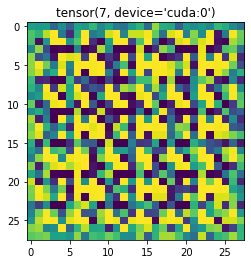

epoch 1 avg of loss: D: 0.693482, G: 0.693346, Info: -0.996766
epoch 2 avg of loss: D: 0.693331, G: 0.693285, Info: -0.997775


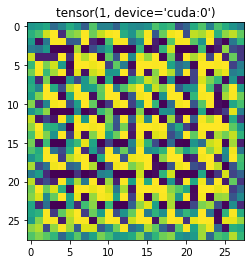

epoch 3 avg of loss: D: 0.693270, G: 0.693233, Info: -0.998187
epoch 4 avg of loss: D: 0.693269, G: 0.693263, Info: -0.998521


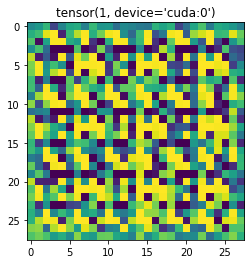

epoch 5 avg of loss: D: 0.693240, G: 0.693222, Info: -0.998581
epoch 6 avg of loss: D: 0.693256, G: 0.693215, Info: -0.998655


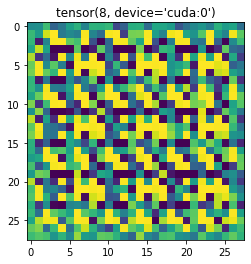

epoch 7 avg of loss: D: 0.693248, G: 0.693204, Info: -0.998331
epoch 8 avg of loss: D: 0.693214, G: 0.693192, Info: -0.998562


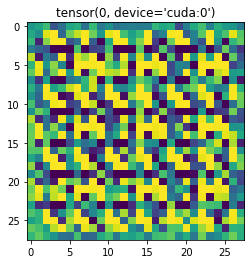

epoch 9 avg of loss: D: 0.694446, G: 0.694095, Info: -0.990864
epoch 10 avg of loss: D: 0.693224, G: 0.693192, Info: -0.998335


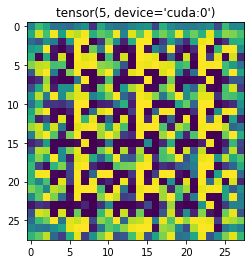

epoch 11 avg of loss: D: 0.693177, G: 0.693171, Info: -0.999071
epoch 12 avg of loss: D: 0.693177, G: 0.693163, Info: -0.999198


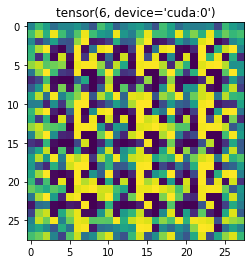

epoch 13 avg of loss: D: 0.693168, G: 0.693177, Info: -0.999257
epoch 14 avg of loss: D: 0.693179, G: 0.693167, Info: -0.998910


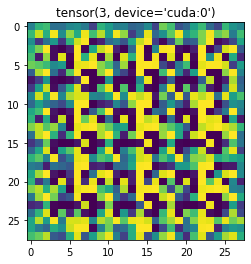

epoch 15 avg of loss: D: 0.693169, G: 0.693208, Info: -0.999102
epoch 16 avg of loss: D: 0.693188, G: 0.693167, Info: -0.999083


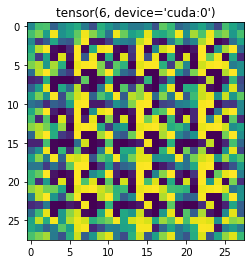

epoch 17 avg of loss: D: 0.693185, G: 0.693182, Info: -0.999166
epoch 18 avg of loss: D: 0.693187, G: 0.693203, Info: -0.998953


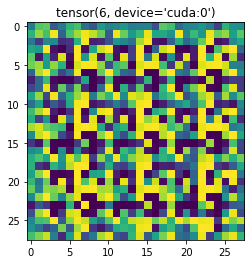

epoch 19 avg of loss: D: 0.693192, G: 0.693179, Info: -0.999108


In [ ]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
#from model import Generator, Discriminator
import torchvision
import itertools
import matplotlib.pyplot as plt

if __name__ == '__main__':
    LR = 0.0002
    EPOCH = 20  # 50
    BATCH_SIZE = 100
    N_IDEAS = 100  # + 10 + 2
    DOWNLOAD_MNIST = False
    TRAINED = False
    mnist_root = '../Conditional-GAN/mnist/'
    if not (os.path.exists(mnist_root)) or not os.listdir(mnist_root):
        # not mnist dir or mnist is empyt dir
        DOWNLOAD_MNIST = True

    train_data = torchvision.datasets.MNIST(
        root=mnist_root,
        train=True,  # this is training data
        transform=torchvision.transforms.ToTensor(),  # Converts a PIL.Image or numpy.ndarray to
        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
        download=DOWNLOAD_MNIST,
    )

    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    torch.cuda.empty_cache()

    if TRAINED:
        G = torch.load('G.pkl').cuda()
        D = torch.load('D.pkl').cuda()
    else:
        G = Generator(N_IDEAS).cuda()
        D = Discriminator(1).cuda()

    optimizerG = torch.optim.Adam(G.parameters(), lr=LR)
    optimizerD = torch.optim.Adam(D.parameters(), lr=LR)
    optimizerInfo = torch.optim.Adam(itertools.chain(G.parameters(), D.parameters()), lr=LR)

    c_c = nn.NLLLoss()  # criterion for classifying
    l_c = nn.MSELoss()
    for epoch in range(EPOCH):
        tmpD, tmpG, tmpInfo = 0, 0, 0
        for step, (x, y) in enumerate(train_loader):
            x = x.cuda()

            z = torch.randn((x.shape[0], N_IDEAS - 10 - 2)).cuda()
            cat_c = torch.zeros((x.shape[0], 10)).scatter_(1, y.unsqueeze(1), 1).cuda()  # one-hot encoding
            lat_c = (torch.rand((x.shape[0], 2)) * 2 - 1).cuda()  # [-1, 1]

            y = y.cuda()

            rand_noise = torch.cat([z, cat_c, lat_c], dim=1).unsqueeze(2).unsqueeze(3)

            G_imgs = G(rand_noise)

            D_fake_D, D_fake_C, D_fake_L = D(G_imgs)
            D_real_D, D_real_C, D_real_L = D(x)

            p_fake = torch.squeeze(D_fake_D)
            p_real = torch.squeeze(D_real_D)

            c_fake = c_c(D_fake_C, y)
            l_fake = l_c(D_fake_L, lat_c)
            # c_real = c_c(D_real_C, y)

            # D_D = -torch.mean(torch.log(p_real) + torch.log(1 - p_fake))  # same as GAN
            # D_C_L = l_fake + c_fake
            # D_loss = D_D + D_C_L
            #
            # G_loss = -torch.mean(torch.log(p_fake)) + D_C_L  # left part is same as GAN

            D_C_L = l_fake + c_fake

            D_D = -torch.mean(torch.log(p_real) + torch.log(1 - p_fake))  # same as GAN
            D_loss = D_D

            G_loss = -torch.mean(torch.log(p_fake))  # same as GAN

            optimizerD.zero_grad()
            optimizerG.zero_grad()
            optimizerInfo.zero_grad()
            D_loss.backward(retain_graph=True)
            G_loss.backward(retain_graph=True)
            D_C_L.backward()



            optimizerD.step()
            optimizerG.step()
            optimizerInfo.step()

            tmpD_ = D_loss.cpu().detach().data
            tmpG_ = G_loss.cpu().detach().data
            tmpInfo_ = D_C_L.cpu().detach().data

            tmpD += tmpD_
            tmpG += tmpG_
            tmpInfo += tmpInfo_

        tmpD /= (step + 1)
        tmpG /= (step + 1)
        tmpInfo /= (step + 1)
        print(
            'epoch %d avg of loss: D: %.6f, G: %.6f, Info: %.6f' % (epoch, tmpD, tmpG, tmpInfo)
        )
        if epoch % 2 == 0:
            plt.title(str(y[0]))
            plt.imshow(torch.squeeze(G_imgs[0].cpu().detach()).numpy())
            plt.show()
    torch.save(G, 'G.pkl')
    torch.save(D, 'D.pkl')

In [ ]:

import numpy as np
import torch
import matplotlib.pyplot as plt
#from model import Generator, Discriminator
import torchvision.utils as vutils


def fixed_C1C3_test_C2(G, c1=0, c3=0, BATCH_SIZE=100, N_IDEAS=100):
    y = torch.from_numpy(np.array([c1 for i in range(BATCH_SIZE)])).type(torch.LongTensor)

    z = torch.randn((BATCH_SIZE, N_IDEAS - 10 - 2)).cuda()
    cat_c = torch.zeros((BATCH_SIZE, 10)).scatter_(1, y.unsqueeze(1), 1).cuda()  # one-hot encoding
    lat_c = torch.from_numpy(
        np.concatenate([np.linspace(-1, 1, BATCH_SIZE // 10).repeat(10)[:, np.newaxis], np.zeros((BATCH_SIZE, 1)) + c3],
                       axis=1)).type(torch.FloatTensor).cuda()
    rand_noise = torch.cat([z, cat_c, lat_c], dim=1).unsqueeze(2).unsqueeze(3)

    G_imgs = G(rand_noise)
    G_imgs = G_imgs.cpu().detach()  # .numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.title("c1:%d c2:-1 to 1 c3: %.1f" % (c1, c3))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(G_imgs, nrow=10, padding=2, normalize=True), (1, 2, 0)))
    plt.savefig("c1_%d_c3_%.1f.png" % (c1, c3), dpi=200)
    plt.show()


def fixed_C1C2_test_C3(G, c1=0, c2=0, BATCH_SIZE=100, N_IDEAS=100):
    y = torch.from_numpy(np.array([c1 for i in range(BATCH_SIZE)])).type(torch.LongTensor)

    z = torch.randn((BATCH_SIZE, N_IDEAS - 10 - 2)).cuda()
    cat_c = torch.zeros((BATCH_SIZE, 10)).scatter_(1, y.unsqueeze(1), 1).cuda()  # one-hot encoding
    lat_c = torch.from_numpy(
        np.concatenate([np.zeros((BATCH_SIZE, 1)) + c2, np.linspace(-1, 1, BATCH_SIZE // 10).repeat(10)[:, np.newaxis]],
                       axis=1)).type(torch.FloatTensor).cuda()
    rand_noise = torch.cat([z, cat_c, lat_c], dim=1).unsqueeze(2).unsqueeze(3)

    G_imgs = G(rand_noise)
    G_imgs = G_imgs.cpu().detach()  # .numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.title("c1:%d c2:%.1f c3:-1 to 1" % (c1, c2))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(G_imgs, nrow=10, padding=2, normalize=True), (1, 2, 0)))
    plt.savefig("c1_%d_c2_%.1f.png" % (c1, c2), dpi=200)
    plt.show()


if __name__ == '__main__':
    BATCH_SIZE = 100

    N_IDEAS = 100

    G = torch.load("G.pkl").cuda()
    for i in range(10):
        fixed_C1C3_test_C2(G, c1=i, c3=0, BATCH_SIZE=BATCH_SIZE, N_IDEAS=N_IDEAS)
    for i in range(10):
        fixed_C1C2_test_C3(G, c1=i, c2=0, BATCH_SIZE=BATCH_SIZE, N_IDEAS=N_IDEAS)
    # ======== c1-test(control numbers) ======== #

    y = torch.from_numpy(np.array([i // 10 for i in range(BATCH_SIZE)])).type(torch.LongTensor)

    z = torch.randn((BATCH_SIZE, N_IDEAS - 10 - 2)).cuda()
    cat_c = torch.zeros((BATCH_SIZE, 10)).scatter_(1, y.unsqueeze(1), 1).cuda()  # one-hot encoding
    lat_c = (torch.zeros((BATCH_SIZE, 2)) - 1).cuda()  # val = -1 [-1, -1]

    rand_noise = torch.cat([z, cat_c, lat_c], dim=1).unsqueeze(2).unsqueeze(3)

    G_imgs = G(rand_noise)
    G_imgs = G_imgs.cpu().detach()  # .numpy()
    print(G_imgs.shape)
    fig = plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(G_imgs, nrow=10, padding=2, normalize=True), (1, 2, 0)))
    plt.savefig('normal.png', dpi=200)
    plt.show()